## This notebook demonstrate how to model the 10 lucky dwarf galaxies in HSC images using [`the tractor`](https://github.com/dstndstn/tractor). 
- `tractor` asks for flux, shape, and morphology type (exponential or Sersic) to initialize a model. In this notebook, the flux and shape are taken from the output of Source Extractor Python (`sep`). The morphology type is taken from the DECaLS catalog (by cross-matching `sep` output catalog with DECaLS catalog). 

- Need help when installing `the tractor`? Check [this website](https://astrojacobli.github.io/blog/2018/10/Macbook-for-Astronomy#install-the-tractor).
- You need to install [`kuaizi`](https://github.com/AstroJacobLi/kuaizi) to run this notebook. `kuaizi` contains some handy tools I often use.

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## Load catalog and images
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')

In [5]:
obj_cat['name']

s18a_wide_226984_y
s18a_wide_233677_y
s18a_wide_238189_y
s18a_wide_240617_y
s18a_wide_255782_y
s18a_wide_265172_y
s18a_wide_274464_y
s18a_wide_275931_y
s18a_wide_277061_y
s18a_wide_301016_y


In [6]:
import scarlet # I only use this package to generate RGB image for display purpose.
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi import task, catalog

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Let's fit a dwarf step by step

In [7]:
channels = 'grizy'

obj = obj_cat[0]
obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in channels
]
psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in channels
]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [8]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

(-0.5, 178.5, -0.5, 178.5)

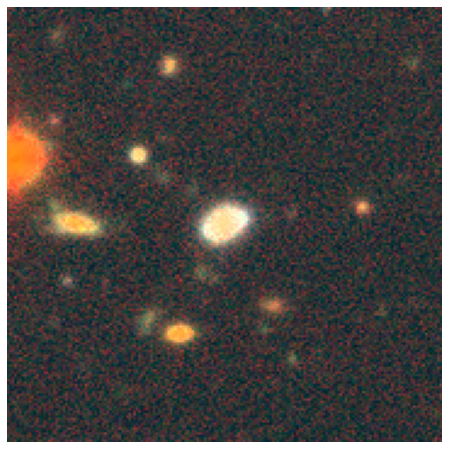

In [9]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb, origin='lower')
plt.axis('off')

In [10]:
## Use Source Extractor to deblend and initialize `tractor`
from kuaizi.tractor.utils import makeCatalog

filt = 'i'
layer_ind = channels.index(filt)

# Detected 18 objects


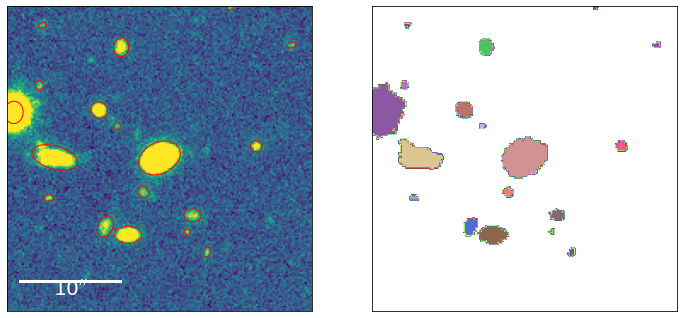

In [11]:
# typical Source Extractor Python (SEP) run, with relatively-low sigma
obj_cat_sep, segmap_sep = makeCatalog(
    [data],
    layer_ind=layer_ind,
    lvl=2.5,
    mask=None,
    method='vanilla',
    convolve=False, 
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=0.168,
    minarea=5,
    deblend_nthresh=48,
    deblend_cont=0.005,
    sky_subtract=True)

In [15]:
## Download DECaLS tractor catalogs and match SEP detection with the tractor catalog
from astropy.table import vstack
from astropy.coordinates import match_coordinates_sky

# DR9 brick catalog, downloaded from https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/
bricks_cat = Table.read(
    '/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz', format='fits')  
# Match bricks with SEP detection
bricks_corr = SkyCoord(
    ra=np.array(bricks_cat['RA']) * u.degree,
    dec=np.array(bricks_cat['DEC']) * u.degree)
detect_coor = SkyCoord(
    ra=obj_cat_sep['ra'] * u.degree, dec=obj_cat_sep['dec'] * u.degree)

to_download = bricks_cat[np.unique(
    match_coordinates_sky(detect_coor, bricks_corr)[0])]
bricknames = to_download['BRICKNAME'].data.astype(
    str)  # in case that there are more than one `tractor` file
print('We need bricks: ', bricknames)
# `bricknames` are tractor files we need.

We need bricks:  ['1496p015' '1496p017']


In [16]:
# Download tractor catalog of the corresponding brick
# This could be time-consuming, depending on internet connection. 
# Maybe we can work on a cluster (such as NERSC or `tiger`) where these `tractor catalogs` can be pre-downloaded.  
tractor_cat = kuaizi.download.download_decals_tractor_catalog(bricknames, layer='dr9', overwrite=False)

./tractor-1496p015.fits: 11.1MB [00:29, 383kB/s]                               


# Downloading ./tractor-1496p015.fits finished! 


./tractor-1496p017.fits: 10.3MB [00:18, 563kB/s]                               


# Downloading ./tractor-1496p017.fits finished! 


In [17]:
# Match these galaxies with DECaLS tractor file and get their morphology types
decals_corr = SkyCoord(
    ra=np.array(tractor_cat['ra']) * u.degree,
    dec=np.array(tractor_cat['dec']) * u.degree)
detect_coor = SkyCoord(ra=obj_cat_sep['ra'] * u.degree, dec=obj_cat_sep['dec'] * u.degree)

temp = tractor_cat[match_coordinates_sky(detect_coor, decals_corr)[0]]
for columns in temp.columns:
    obj_cat_sep.add_column(temp[columns], rename_duplicate=True)
obj_cat_sep.sort('flux', reverse=True)
obj_cat_sep

obj_type,index,x,y,ra,dec,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,flux_max,fwhm_custom,R30,R50,R80,flux_auto,kron_rad,release,brickid,brickname,objid,brick_primary,maskbits,fitbits,type,ra_1,dec_1,ra_ivar,dec_ivar,bx,by,dchisq [5],ebv,mjd_min,mjd_max,ref_cat,ref_id,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,ref_epoch,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_g_n_obs,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_bp_n_obs,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_phot_rp_n_obs,gaia_phot_variable_flag,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_astrometric_n_obs_al,gaia_astrometric_n_good_obs_al,gaia_astrometric_weight_al,gaia_duplicated_source,gaia_a_g_val,gaia_e_bp_min_rp_val,gaia_phot_bp_rp_excess_factor,gaia_astrometric_sigma5d_max,gaia_astrometric_params_solved,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,fiberflux_g,fiberflux_r,fiberflux_z,fibertotflux_g,fibertotflux_r,fibertotflux_z,apflux_g [8],apflux_r [8],apflux_z [8],apflux_resid_g [8],apflux_resid_r [8],apflux_resid_z [8],apflux_blobresid_g [8],apflux_blobresid_r [8],apflux_blobresid_z [8],apflux_ivar_g [8],apflux_ivar_r [8],apflux_ivar_z [8],apflux_masked_g [8],apflux_masked_r [8],apflux_masked_z [8],apflux_w1 [5],apflux_w2 [5],apflux_w3 [5],apflux_w4 [5],apflux_resid_w1 [5],apflux_resid_w2 [5],apflux_resid_w3 [5],apflux_resid_w4 [5],apflux_ivar_w1 [5],apflux_ivar_w2 [5],apflux_ivar_w3 [5],apflux_ivar_w4 [5],mw_transmission_g,mw_transmission_r,mw_transmission_z,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_g,nobs_r,nobs_z,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_g,fracflux_r,fracflux_z,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_g,fracmasked_r,fracmasked_z,fracin_g,fracin_r,fracin_z,anymask_g,anymask_r,anymask_z,allmask_g,allmask_r,allmask_z,wisemask_w1,wisemask_w2,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,nea_g,nea_r,nea_z,blob_nea_g,blob_nea_r,blob_nea_z,psfdepth_w1,psfdepth_w2,psfdepth_w3,psfdepth_w4,wise_coadd_id,wise_x,wise_y,lc_flux_w1 [15],lc_flux_w2 [15],lc_flux_ivar_w1 [15],lc_flux_ivar_w2 [15],lc_nobs_w1 [15],lc_nobs_w2 [15],lc_fracflux_w1 [15],lc_fracflux_w2 [15],lc_rchisq_w1 [15],lc_rchisq_w2 [15],lc_mjd_w1 [15],lc_mjd_w2 [15],lc_epoch_index_w1 [15],lc_epoch_index_w2 [15],sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,1/deg^2,1/deg^2,,,,mag,,,,,mas / yr,mas / yr,mas,1/(mas/yr)^2,1/(mas/yr)^2,1/mas^2,,mag,,,mag,,,mag,,,,,,,,,,,,,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,arcsec,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,arcsec,1/arcsec^2,,,,
object,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,

In [19]:
catalog_c = SkyCoord(obj_cat_sep['ra'], obj_cat_sep['dec'], unit='deg')
dist = coord.separation(catalog_c)
cen_obj_ind = np.argsort(dist)[0]
cen_obj = obj_cat_sep[cen_obj_ind]

print(f'# Type of central object is {cen_obj["type"]}')
print(f'# Total number of objects: {len(obj_cat_sep)}')

# Type of central object is SER
# Total number of objects: 18


In [20]:
#obj_cat_sex['type'][obj_cat_sex['type'] == 'PSF'] = 'REX'

 - Now you have 2 sources
 - Now you have 18 sources


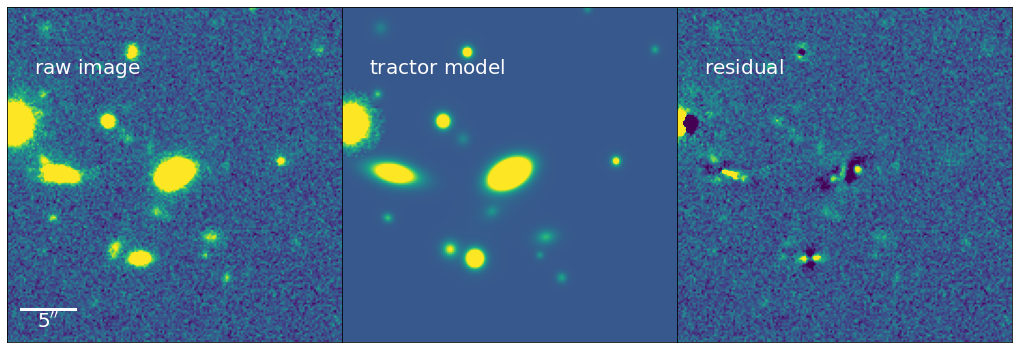

   The chi-square is 0.0001547232


In [21]:
from tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_iteration
psf_obj = PixelizedPSF(data.psfs[layer_ind]) # Construct PSF

sources, trac_obj, fig = tractor_iteration(
    obj_cat_sep,
    data.wcs,
    data.images[layer_ind],
    data.weights[layer_ind],
    psf_obj,
    kuaizi.HSC_pixel_scale,
    shape_method='decals',
    freeze_pos=True, # whether freeze positions of objects during fitting
    kfold=2, # how many rounds 
    first_num=cen_obj_ind + 1, # the number of objects for the first round
    fig_name='test')

Evaluating FFT mixture: 5 components in size 256 256
Amps: [5.64982241e-01 3.71484522e-01 5.74006667e-02 5.78001916e-03
 3.52551200e-04]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-02 1.00186544e-01
 3.68534484e-01 5.09490694e-01]
Evaluating FFT mixture: 6 components in size 128 128
Amps: [1.99485977e-04 2.61612679e-03 1.89726655e-0

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

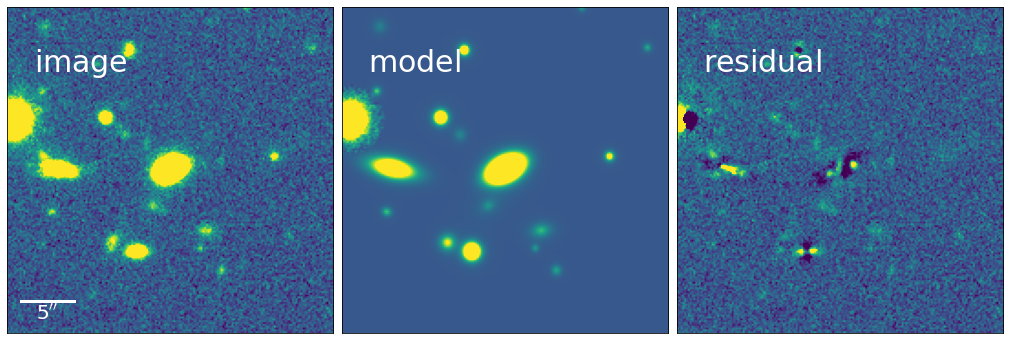

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

trac_mod = trac_obj.getModelImage(0, srcs=sources)

kuaizi.display.display_multiple(
    [data.images[layer_ind], trac_mod, data.images[layer_ind] - trac_mod],
    text=['image', 'model', 'residual'],
    ax=axes,
    scale_bar_y_offset=0.4)

## I've incorporate the above steps into `kuaizi.tractor.utils.tractor_sep` function.

In [23]:
from kuaizi.tractor.utils import tractor_hsc_sep

In [24]:
channels = 'grizy'

In [27]:
# Save all the files to './sep-decals'
import os
os.chdir('./sep-decals/')

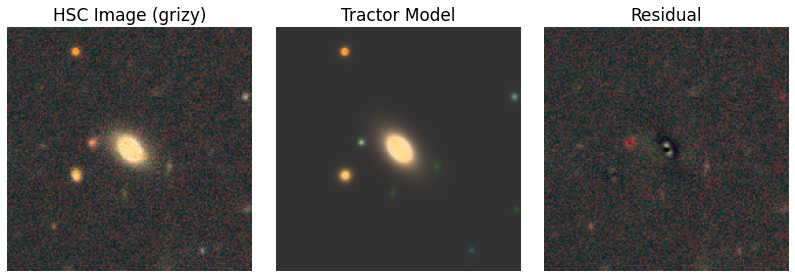

In [31]:
for obj in obj_cat[1:]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('s18a_wide')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    
    # Start fitting
    model_dict = {}
    for filt in channels:
        model_dict[filt] = tractor_hsc_sep(obj, filt, channels, data, 
                                           brick_file='/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz',
                                           freeze_pos=False, verbose=False)
    
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
        
    ### Make figures into a PDF file (slow)
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
        pdf.image(image, 21, 11 + k * 55, 167, 55)
    pdf.output(obj_name + "_sep_tractor.pdf", "F")

    # Visualize our model
    from kuaizi.tractor.utils import HiddenPrints
    with HiddenPrints():
        model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

    stretch = 1
    Q = 0.5
    channel_map = scarlet.display.channels_to_rgb(len(channels))

    img_rgb = scarlet.display.img_to_rgb(
        data.images,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    model_rgb = scarlet.display.img_to_rgb(
        model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    res_rgb = scarlet.display.img_to_rgb(
        data.images - model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
    ax1.imshow(img_rgb, origin='lower')
    ax2.imshow(model_rgb, origin='lower')
    ax3.imshow(res_rgb, origin='lower')

    for ax in [ax1, ax2, ax3]:
        ax.axis('off')

    ax1.set_title('HSC Image (grizy)', fontsize=17)
    ax2.set_title('Tractor Model', fontsize=17)
    ax3.set_title('Residual', fontsize=17)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(obj_name + '_sep_tractor_rgb.png', 
                bbox_inches='tight', 
                metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})
    

    clear_output()
    #plt.close()